# Discovering the Kraichnan-Orszag system from data

### Main Article-
- https://readmedium.com/discovering-differential-equations-with-physics-informed-neural-networks-and-symbolic-regression-c28d279c0b4d

### Some more articles to read-
- https://readmedium.com/operator-learning-via-physics-informed-deeponet-lets-implement-it-from-scratch-6659f3179887
- https://i-systems.github.io/tutorial/KSME/CAE/220520/01_PINN.html
- https://docs.sciml.ai/NeuralPDE/stable/manual/ode/

### Objective

In this notebook, we investigate combining PINN with symbolic regression to discover ODE systems. Our target ODE system can be written as follows:

Let u_1 = psi_e, u_2 = b_e, u_3 = psi_plus, u_4 = b_plus. u_5 = U

\begin{align}
    \frac{d \psi_e}{dt} &= -\psi_e + (k / k_e^2)b_e + U  (-(k  (k_+^2 - m_U^2)) / (2  k_e^2))  \psi_+ + \sqrt(\epsilon) \times noise \\
    \frac{d b_e}{dt} &= -kN_0^2  \psi_e - b_e + (k / 2)  U  \psi_+ \\
    \frac{d \psi_+}{dt} &= -\psi_+ - (k / k_+^2)  b_+ + U  (-(k  (m_U^2 - k_e^2)) / (2  k_+^2))  \psi_e \\
    \frac{d b_+}{dt} &= k  N_0^2  \psi_+ - b_+ - (k / 2)  U  \psi_e \\
    \frac{d U}{dt} &= 0.25  k  (k_p^2 - k_e^2)  \psi_e  \psi_p - (r_m  U) \\
\end{align}

Substituting,in python,

\begin{align}
    \frac{d u_1}{dt} &= -u_1 + (k / k_e**2) * u_2 + u_5 * (-(k * (k_plus**2 - m_U**2)) / (2 * k_e**2)) * u_3 + np.sqrt(epsilon) * noise \\
    \frac{d u_2}{dt} &= -k * N0_squared * u_1 - u_2 + (k / 2) * u_5 * u_3 \\
    \frac{d u_3}{dt} &= -u_3 - (k / k_plus**2) * u_4 + u_5 * (-(k * (m_U**2 - k_e**2)) / (2 * k_plus**2)) * u_1 \\
    \frac{d u_4}{dt} &= k * N0_squared * u_3 - u_4 - (k / 2) * u_5 * u_1 \\
    \frac{d u_5}{dt} &= 0.25 * k * (k_plus**2 - k_e**2) * u_1 * u_3 - r_m * u_5 \\
\end{align}


with an initial condition of $u_1(0)=0, u_2(0)=0, u_3(0)=0, u_4(0)=0, u_5(0)=0.001$.

For our case study, we assume that we only know the right-hand side of the third equation to be a linear transformation of $u_1u_2$, and have no knowledge of the first two equations. Essentially, we can rewrite the ODE system as follows:

\begin{align}
    \frac{du_1}{dt} &= f_1(t, u_1, u_2, u_3, u_5) \\
    \frac{du_2}{dt} &= f_2(t, u_1, u_2, u_3) \\
    \frac{du_3}{dt} &= f_3(t, u_1, u_3, u_4, u_5) \\
    \frac{du_4}{dt} &= f_4(t, u_1, u_3, u_4, u_5) \\
    \frac{du_5}{dt} &= a u_1u_3 - r_m u_5 + b \\
\end{align}

where $a, b$ are unknown coefficients and $f_1, f_2, f_3, f_4$ are the unknown functions. By using PINN and symbolic regression, we aim to calibrate the values of $a$ and $b$, as well as the functional forms of $f_1, f_2, f_3, and f_4$.

### 0. Import libraries

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.integrate import solve_ivp
from collections import defaultdict
import sdeint
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

2023-12-29 05:26:54.873610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 1. Observational data generation

To begin with, we need to generate simulation data of the investigated ODE system, which will be used later for inverse calibration.

In [9]:
# Define all the constants
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

epsilon = 0.01

noise = np.random.normal(0, 1)

In [10]:
def simulate_ODEs(u_init, t_span, obs_num):
    """Simulate the ODE system and obtain observational data. 
    
    Args:
    ----
    u_init: list of initial condition for u1, u2, and u3
    t_span: lower and upper time limit for simulation
    obs_num: number of observational data points
    
    Outputs:
    --------
    u_obs: observed data for u's
    """
    
    # Define the target ODEs
    def odes(t, u):
        du1dt = -u[0] + (k / k_e**2) * u[1] + u[4] * (-(k * (k_plus**2 - m_U**2)) / (2 * k_e**2)) * u[2] + np.sqrt(epsilon) * noise
        du2dt = -k * N0_squared * u[0] - u[1] + (k / 2) * u[4] * u[2]
        du3dt = -u[2] - (k / k_plus**2) * u[3] + u[4] * (-(k * (m_U**2 - k_e**2)) / (2 * k_plus**2)) * u[0]
        du4dt = k * N0_squared * u[2] - u[3] - (k / 2) * u[4] * u[0]
        du5dt = 0.25 * k * (k_plus**2 - k_e**2) * u[0] * u[2] - r_m * u[4]
        return [du1dt, du2dt, du3dt, du4dt, du5dt]
    
    # Solve ODEs
    t_eval = np.linspace(t_span[0], t_span[1], obs_num)
    sol = solve_ivp(odes, t_span, u_init, method='RK45', t_eval=t_eval)
    
    # Restrcture obtained data
    u_obs = np.column_stack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4]))
    
    return u_obs


In [11]:
# import sdeint

# def f(u, t):
#     du1dt = -u[0] + (k / k_e**2) * u[1] + u[4] * (-(k * (k_plus**2 - m_U**2)) / (2 * k_e**2)) * u[2]
#     du2dt = -k * N0_squared * u[0] - u[1] + (k / 2) * u[4] * u[2]
#     du3dt = -u[2] - (k / k_plus**2) * u[3] + u[4] * (-(k * (m_U**2 - k_e**2)) / (2 * k_plus**2)) * u[0]
#     du4dt = k * N0_squared * u[2] - u[3] - (k / 2) * u[4] * u[0]
#     du5dt = 0.25 * k * (k_plus**2 - k_e**2) * u[0] * u[2] - r_m * u[4]
#     return np.array([du1dt, du2dt, du3dt, du4dt, du5dt])

# def g(u, t):
#     return np.array([[np.sqrt(epsilon)], [0], [0], [0], [0]])


# y0 = [0, 0, 0, 0, 0.001]
# obs_num = 1000000
# tspan = np.linspace(0, 200, obs_num) 
# rng = np.random.default_rng()

# u_obs = sdeint.itoEuler(f, g, y0, tspan, generator=rng)

In [12]:
# # Set up simulation
# u_init = [0, 0, 0, 0, 0.001]
# t_span = [0, 200]
# obs_num = 10000

# # Solve ODEs
# u_obs = simulate_ODEs(u_init, t_span, obs_num)

In [13]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]
t_span = (0, 200)
dt = 0.001
epsilon = 0.01  #noise strength (0.01 has been well used)


#The function below uses the Euler Maruyama method which is used to solve Stochastic Differential Equations (SDEs)
def euler_maruyama(y0, t_span, dt, epsilon, seed=None):
    np.random.seed(seed)
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt))
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.normal(0, 1)
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U[i] * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.column_stack((t, s.T, U))
    return y

u_obs = euler_maruyama(initial_state, t_span, dt, epsilon)

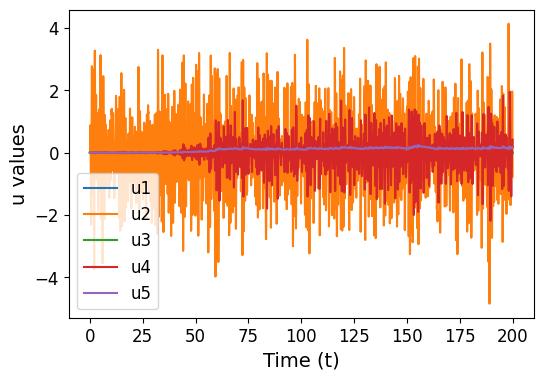

In [14]:
# Visualize the results
plt.figure(figsize=(6, 4))

plt.plot(u_obs[:, 0], u_obs[:, 1], label='u1')
plt.plot(u_obs[:, 0], u_obs[:, 2], label='u2')
plt.plot(u_obs[:, 0], u_obs[:, 3], label='u3')
plt.plot(u_obs[:, 0], u_obs[:, 4], label='u4')
plt.plot(u_obs[:, 0], u_obs[:, 5], label='u5')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('u values', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, frameon=True)

plt.savefig('u_profile.png', bbox_inches='tight', transparent=True)

### 2. Organize dataset

In [15]:
# Set batch size
data_batch_size = 20000
ODE_batch_size = 200000

# Samples for enforcing data loss
X_train_data = tf.convert_to_tensor(u_obs[:, :1], dtype=tf.float32)
y_train_data = tf.convert_to_tensor(u_obs[:, 1:], dtype=tf.float32)
train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
train_ds_data = train_ds_data.shuffle(200000).batch(data_batch_size)

# Samples for enforcing ODE residual loss
N_collocation = 2000000
X_train_ODE = tf.convert_to_tensor(np.linspace(0, 200, N_collocation).reshape(-1, 1), dtype=tf.float32)
train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

# Generate testing data
u_obs_test = euler_maruyama(initial_state, t_span, dt/5, epsilon)
X_test, y_test = u_obs_test[:, :1], u_obs_test[:, 1:]

### 3. Physics-informed Neural Networks

#### Define a custom layer for hosting unknown parameters

In [16]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable
        
    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)
        
    def get_config(self):
        return super().get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed Neural Network

In [33]:
def u_net(input_layer):
    """Definition of the network for u prediction."""
    
    hidden = input_layer
    for _ in range(2):
        hidden = tf.keras.layers.Dense(100, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(5)(hidden)
    return output


def f_net(input_layers, a_init=None, b_init=None):
    """Definition of the network for f prediction."""
    
    hidden = tf.keras.layers.Concatenate()(input_layers)
    for _ in range(2):
        hidden = tf.keras.layers.Dense(100, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(2)(hidden)
    output = ParameterLayer(a_init, b_init)(output)
    return output


def create_PINN(a_init=None, b_init=None, verbose=False):
    """Definition of a physics-informed neural network.
    
    Args:
    ----
    a_init: initial value for parameter a
    b_init: initial value for parameter b
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the PINN model
    """
    # Input
    t_input = tf.keras.Input(shape=(1,), name="time")
    
    # u-NN
    u = u_net(t_input)
    
    # f-NN
    f = f_net([t_input, u], a_init, b_init)

    # PINN model
    model = tf.keras.models.Model(inputs=t_input, outputs=[u, f])
    
    if verbose:
        model.summary()
        
    return model

#### ODE loss

In [34]:
@tf.function
def ODE_residual_calculator(t, model):
    """ODE residual calculation.
    
    Args:
    ----
    t: temporal coordinate
    model: PINN model
    
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    
    # Retrieve parameters
    a = model.layers[-1].a
    b = model.layers[-1].b
    
    with tf.GradientTape() as tape:
        tape.watch(t)
        u, f = model(t)
    
    # Calculate gradients
    dudt = tape.batch_jacobian(u, t)[:, :, 0]
    du1_dt, du2_dt, du3_dt, du4_dt, du5_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:3], dudt[:, 3:4], dudt[:, 4:]
    
    '''
    \begin{align}
    \frac{du_1}{dt} &= f_1(t, u_1, u_2, u_3, u_5) \\
    \frac{du_2}{dt} &= f_2(t, u_1, u_2, u_3) \\
    \frac{du_3}{dt} &= f_3(t, u_1, u_3, u_4, u_5) \\
    \frac{du_4}{dt} &= f_4(t, u_1, u_3, u_4, u_5) \\
    \frac{du_5}{dt} &= a u_1u_3 - r_m u_5 + b \\
    \end{align}
    '''
    # Compute residuals
    res1 = du1_dt - f[:, 0:1]
    res2 = du2_dt - f[:, 1:2]
    res3 = du3_dt - (-u[:, 2:3] - (k / k_plus**2) * u[:, 3:4] + u[:, 4:5] * (-(k * (m_U**2 - k_e**2)) / (2 * k_plus**2)) * u[:, 0:1])
    res4 = du4_dt - (k * N0_squared * u[:, 2:3] - u[:, 3:4] - (k / 2) * u[:, 4:5] * u[:, 0:1])
    res5 = du5_dt - a*((0.25 * k * (k_plus**2 - k_e**2))*u[:, 0:1]*u[:, 2:3] - r_m*u[:, 4:5] + b)
    ODE_residual = tf.concat([res1, res2, res3, res4, res5], axis=1)
    
    return ODE_residual

#### Gradient descent step

In [35]:
@tf.function
def train_step(X_ODE, X, y, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X_ODE: Collocation points for evaluating ODE residuals
    X: observed samples
    y: target values of the observed samples
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: PINN model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC, _ = model(tf.zeros((1, 1)))

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X_ODE, model=model)
        
        # Data loss
        y_pred_data, _ = model(X)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(tf.constant([[0, 0, 0, 0, 0.001]]), y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))
        
        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define loss tracking class

In [36]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [37]:
class PrintParameters(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training

In [38]:
# Set up training configurations
n_epochs = 1000
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# Initial value for unknown parameters
a_init, b_init = 1, 0

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-2)

with tf.device("GPU:0"):
    
    # Instantiate the PINN model
    PINN = create_PINN(a_init=a_init, b_init=b_init)
    PINN.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=100),
                 tf.keras.callbacks.ModelCheckpoint('PINN_model_2.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PINN)
    
    # Start training process
    for epoch in range(1, n_epochs + 1):  
        print(f"Epoch {epoch}:")

        for (X_ODE), (X, y) in zip(train_ds_ODE, train_ds_data):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X_ODE, X, y, IC_weight, 
                                                                             ODE_weight, data_weight, PINN)
            # Gradient descent
            PINN.optimizer.apply_gradients(zip(gradients, PINN.trainable_variables))

            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()
        
        # Parameter recording
        a_list.append(PINN.layers[-1].a.numpy())
        b_list.append(PINN.layers[-1].b.numpy())

        ####### Validation
        val_res = ODE_residual_calculator(tf.reshape(tf.linspace(0.0, 200.0, 200000), [-1, 1]), PINN)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        u_init=tf.constant([[0, 0, 0, 0, 0.001]])
        val_pred_init, _ = PINN.predict(tf.zeros((1, 1)))
        val_IC = tf.reduce_mean(tf.square(val_pred_init - u_init))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PINN.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test, _ = PINN.predict(X_test, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")
        
        
        # Re-shuffle dataset
        train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
        train_ds_data = train_ds_data.shuffle(200000).batch(data_batch_size) 
        
        train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
        train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size) 

Epoch 1:


IC=5.1358e-03,               ODE=8.4241e+09,               data=4.2428e+00,               total_loss=8.4241e+09
1/1 [==============================] - 0s 38ms/step
val_IC: 6.4605e-03, val_ODE: 1.5010e+08, lr: 1.00e-02

a: [0.9386196], b: [0.00909798]
79/79 [==============================] - 0s 701us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 2.1594469140909855
Epoch 2:
IC=5.4493e-03,               ODE=3.4470e+08,               data=8.9350e+00,               total_loss=3.4470e+08
1/1 [==============================] - 0s 13ms/step
val_IC: 6.1103e-03, val_ODE: 9.1612e+07, lr: 1.00e-02

a: [0.9161233], b: [0.0057204]
79/79 [==============================] - 0s 574us/step
RMSE: 4.484769672950164
Epoch 3:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6520e-03,               ODE=1.2163e+08,               data=4.0361e+01,               total_loss=1.2163e+08
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5890e-02, val_ODE: 1.3253e+08, lr: 1.00e-02

a: [0.90659255], b: [0.0045748]
79/79 [==============================] - 0s 565us/step
RMSE: 8.57388487725843
Epoch 4:
IC=2.6473e-02,               ODE=8.1539e+07,               data=1.1162e+02,               total_loss=8.1539e+07
1/1 [==============================] - 0s 10ms/step
val_IC: 4.0536e-02, val_ODE: 5.0432e+07, lr: 1.00e-02

a: [0.90251195], b: [0.00343008]
79/79 [==============================] - 0s 564us/step
RMSE: 12.87582763631304


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 5:
IC=5.4130e-02,               ODE=5.5724e+07,               data=2.2056e+02,               total_loss=5.5724e+07
1/1 [==============================] - 0s 10ms/step
val_IC: 7.4016e-02, val_ODE: 5.4865e+07, lr: 1.00e-02

a: [0.9008046], b: [0.00303359]
79/79 [==============================] - 0s 627us/step
RMSE: 17.124801092272357
Epoch 6:
IC=9.3080e-02,               ODE=4.7323e+07,               data=3.6274e+02,               total_loss=4.7323e+07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.2163e-01, val_ODE: 4.1942e+07, lr: 1.00e-02

a: [0.90009886], b: [0.00342393]
79/79 [==============================] - 0s 540us/step
RMSE: 21.278152191970136
Epoch 7:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5364e-01,               ODE=4.1302e+07,               data=5.3450e+02,               total_loss=4.1302e+07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9785e-01, val_ODE: 3.9682e+07, lr: 1.00e-02

a: [0.8998138], b: [0.00365084]
79/79 [==============================] - 0s 563us/step
RMSE: 25.300067638404663
Epoch 8:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4617e-01,               ODE=3.7536e+07,               data=7.3327e+02,               total_loss=3.7537e+07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1137e-01, val_ODE: 3.5388e+07, lr: 1.00e-02

a: [0.899699], b: [0.00360233]
79/79 [==============================] - 0s 573us/step
RMSE: 29.194660092387114
Epoch 9:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7611e-01,               ODE=3.4111e+07,               data=9.5633e+02,               total_loss=3.4112e+07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.6306e-01, val_ODE: 3.2479e+07, lr: 1.00e-02

a: [0.899653], b: [0.00365397]
79/79 [==============================] - 0s 586us/step
RMSE: 32.980373461129204
Epoch 10:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4419e-01,               ODE=3.1098e+07,               data=1.2012e+03,               total_loss=3.1099e+07
1/1 [==============================] - 0s 13ms/step
val_IC: 6.5047e-01, val_ODE: 2.9479e+07, lr: 1.00e-02

a: [0.8996343], b: [0.00383044]
79/79 [==============================] - 0s 550us/step
RMSE: 36.6586402945982
Epoch 11:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


KeyboardInterrupt: 

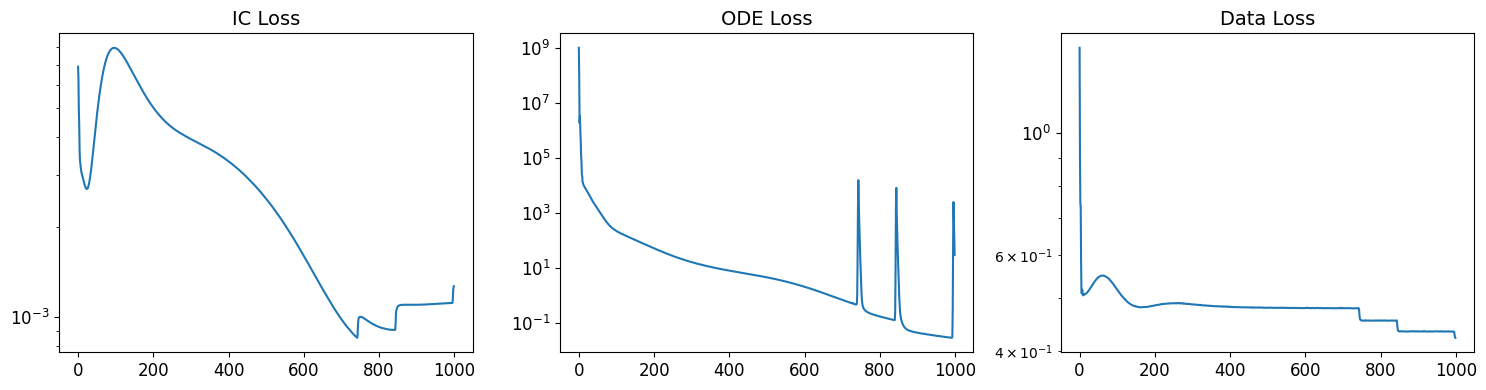

In [ ]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'])
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

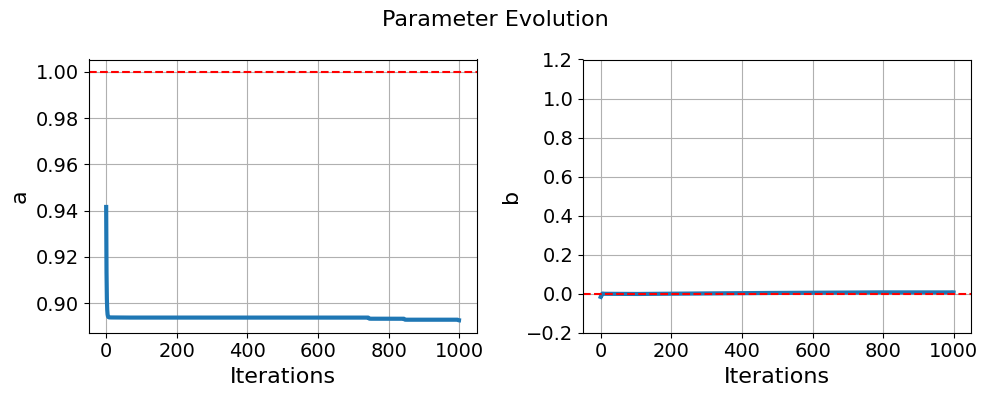

In [ ]:
# Parameter history
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(n_epochs), a_list, lw=3)
ax[0].set_ylabel('a', fontsize=16)
ax[0].set_xlabel('Iterations', fontsize=16)
# ax[0].set_ylim((-2.2, -0.7))
ax[0].axhline(y=1, color='r', linestyle='--')

ax[1].plot(range(n_epochs), b_list, lw=3)
ax[1].set_ylabel('b', fontsize=16)
ax[1].set_xlabel('Iterations', fontsize=16)
ax[1].set_ylim((-0.2, 1.2))
ax[1].axhline(y=0, color='r', linestyle='--')

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.grid(True)
fig.suptitle('Parameter Evolution', fontsize=16)
plt.tight_layout()

#### Collect input/output of f-NN 

In [97]:
t = np.linspace(0, 200, 200000).reshape(-1, 1)
u, f = PINN.predict(t, batch_size=12800)

# Configure dataframe
df = pd.DataFrame({
    't': t.flatten(),
    'u1': u[:, 0],
    'u2': u[:, 1],
    'u3': u[:, 2],
    'u4': u[:, 3],
    'u5': u[:, 4],
    'f1': f[:, 0],
    'f2': f[:, 1],
    'f3': f[:, 2],
    'f4': f[:, 3],
    'f5': f[:, 4]
})
df.to_csv('f_NN_IO.csv', index=False)

16/16 [==============================] - 0s 607us/step


IndexError: index 2 is out of bounds for axis 1 with size 2

Text(0.5, 1.0, 'f2')

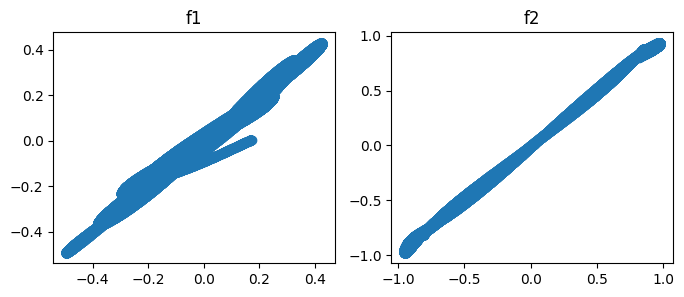

In [17]:
# Sanity check
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].scatter(np.exp(-df.t.values/10)*df.u2.values*df.u3.values, df.f1)
ax[0].set_title('f1')

ax[1].scatter(df.u1.values*df.u3.values, df.f2)
ax[1].set_title('f2')

#### Assess accuracy: u prediction

In [119]:
t = np.linspace(0, 200, 1000000).reshape(-1, 1)
pred_u, pred_f = PINN.predict(t, batch_size=12800)

79/79 [==============================] - 0s 598us/step


/tmp/ipykernel_375625/3288314124.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


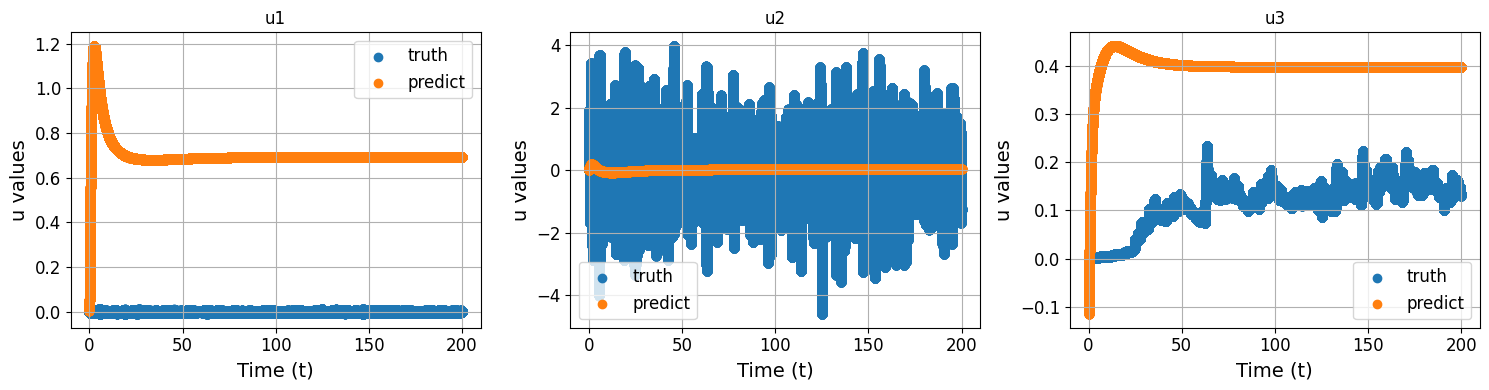

In [124]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(t.flatten(), y_test[:, 0], label='truth')
ax[0].scatter(t.flatten(), pred_u[:, 0], label='predict')
ax[0].set_title('u1')
ax[1].scatter(t.flatten(), y_test[:, 1], label='truth')
ax[1].scatter(t.flatten(), pred_u[:, 1], label='predict')
ax[1].set_title('u2')
ax[2].scatter(t.flatten(), y_test[:, 4], label='truth')
ax[2].scatter(t.flatten(), pred_u[:, 4], label='predict')
ax[2].set_title('u3')

for axs in ax:
    axs.set_xlabel('Time (t)', fontsize=14)
    axs.set_ylabel('u values', fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.legend(fontsize=12, frameon=True)
    axs.grid(True)

plt.tight_layout()

#### Access accuracy: f prediction

In [13]:
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_test)
    u, f = PINN(X_test)

# Calculate gradients
dudt = tape.batch_jacobian(u, X_test)[:, :, 0]
du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

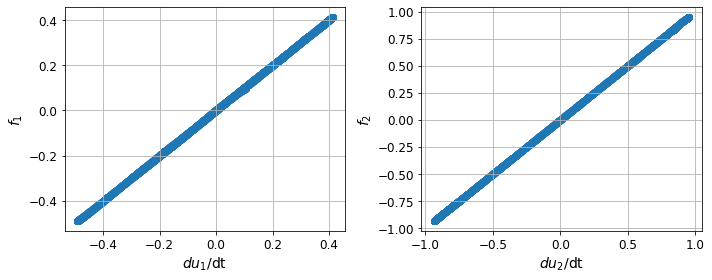

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(du1_dt.numpy().flatten(), f[:, 0].numpy())
ax[0].set_xlabel('$du_1$/dt', fontsize=14)
ax[0].set_ylabel('$f_1$', fontsize=14)
ax[1].scatter(du2_dt.numpy().flatten(), f[:, 1].numpy())
ax[1].set_xlabel('$du_2$/dt', fontsize=14)
ax[1].set_ylabel('$f_2$', fontsize=14)

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.grid(True)

plt.tight_layout()